In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
import math
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

## **Data Cleaning Preprocessing**

Dataset is large, to speed up counting I've chosen only a part of dataset.

In [ ]:
p = 0.01  # 1% of the lines
# keep the header, then take only 1% of lines
#wczytanie losowych danych ze zbioru
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/flights.csv', header=0, 
         skiprows=lambda i: i>0 and random.random() > p)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,DL,2453,N966DL,GSP,ATL,550,550.0,0.0,26.0,616.0,59,59.0,28.0,153,644.0,5.0,649,649.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,OO,6204,N917SW,BFL,DEN,550,556.0,6.0,31.0,627.0,150,164.0,125.0,845,932.0,8.0,920,940.0,20.0,0,0,NaN,14.0,0.0,6.0,0.0,0.0
3,2015,1,1,4,US,646,N654AW,OAK,PHX,600,558.0,-2.0,28.0,626.0,115,125.0,88.0,646,854.0,9.0,855,903.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,MQ,2962,N609MQ,CLL,DFW,600,NaN,NaN,NaN,NaN,60,NaN,NaN,164,NaN,NaN,700,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58441 entries, 0 to 58440
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 58441 non-null  int64  
 1   MONTH                58441 non-null  int64  
 2   DAY                  58441 non-null  int64  
 3   DAY_OF_WEEK          58441 non-null  int64  
 4   AIRLINE              58441 non-null  object 
 5   FLIGHT_NUMBER        58441 non-null  int64  
 6   TAIL_NUMBER          58315 non-null  object 
 7   ORIGIN_AIRPORT       58441 non-null  object 
 8   DESTINATION_AIRPORT  58441 non-null  object 
 9   SCHEDULED_DEPARTURE  58441 non-null  int64  
 10  DEPARTURE_TIME       57609 non-null  float64
 11  DEPARTURE_DELAY      57609 non-null  float64
 12  TAXI_OUT             57575 non-null  float64
 13  WHEELS_OFF           57575 non-null  float64
 14  SCHEDULED_TIME       58441 non-null  int64  
 15  ELAPSED_TIME         57411 non-null 

usunięcie NaN i wybranie przydatnych kolumn

In [ ]:
df= df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME']]
df = df.dropna()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57411 entries, 0 to 57410
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AIRLINE              57411 non-null  object 
 1   ORIGIN_AIRPORT       57411 non-null  object 
 2   DESTINATION_AIRPORT  57411 non-null  object 
 3   SCHEDULED_DEPARTURE  57411 non-null  int64  
 4   DEPARTURE_TIME       57411 non-null  float64
 5   DEPARTURE_DELAY      57411 non-null  float64
 6   SCHEDULED_ARRIVAL    57411 non-null  int64  
 7   ARRIVAL_TIME         57411 non-null  float64
 8   ARRIVAL_DELAY        57411 non-null  float64
 9   SCHEDULED_TIME       57411 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 4.4+ MB


In [ ]:
#date_format_str = '%Y/%m/%d %H:%M:%S'
#df['DATE']= pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
#df=df.drop(columns=['YEAR', 'MONTH', 'DAY'])
#df.head()

Checking if there are any null values left.

In [ ]:
df.isnull().values.any()

False

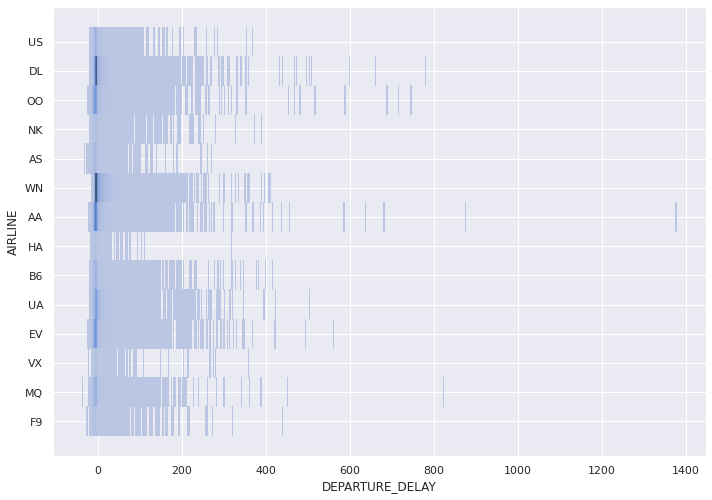

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df, x='DEPARTURE_DELAY', y='AIRLINE') 

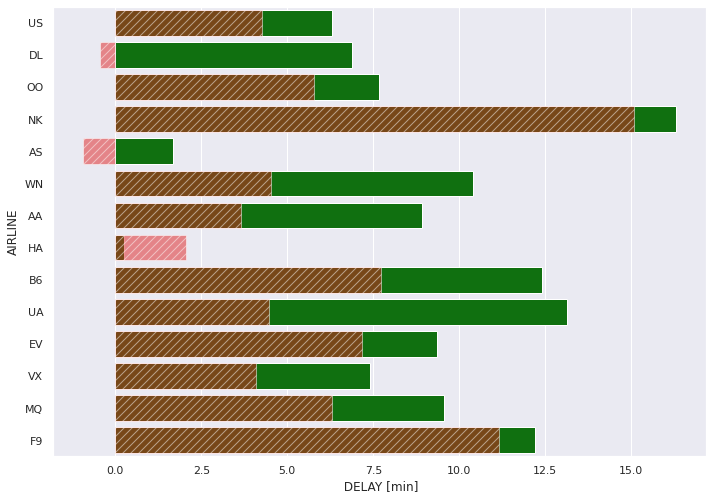

In [ ]:
ax = plt.subplots()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="green", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="red", hatch = '///',alpha = 0.5, ci=None)
ax.set(xlabel=" DELAY [min]", ylabel="AIRLINE")
plt.show()

Adding label column, where 1 means that flight was delayed more than 60 min and 0 otherwise. Stron correlated column with y label is DEPARTURE_DELAY.


In [ ]:
label=[]
for i in range (len(df)):
  if df['DEPARTURE_DELAY'][i]>60:
    label = np.append(label,1)
  else:
    label = np.append(label,0)
df['label']=label
df=df.drop(columns=['DEPARTURE_DELAY'])
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,label
0,US,SFO,CLT,20,18.0,806,811.0,5.0,286,0.0
1,DL,GSP,ATL,550,550.0,649,649.0,0.0,59,0.0
2,OO,BFL,DEN,550,556.0,920,940.0,20.0,150,0.0
3,US,OAK,PHX,600,558.0,855,903.0,8.0,115,0.0
4,NK,DTW,LGA,600,558.0,738,836.0,58.0,98,0.0


In [ ]:
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,label
0,US,SFO,CLT,20,18.0,806,811.0,5.0,286,0.0
1,DL,GSP,ATL,550,550.0,649,649.0,0.0,59,0.0
2,OO,BFL,DEN,550,556.0,920,940.0,20.0,150,0.0
3,US,OAK,PHX,600,558.0,855,903.0,8.0,115,0.0
4,NK,DTW,LGA,600,558.0,738,836.0,58.0,98,0.0


In [ ]:
df.label.value_counts(normalize=True)

0.0    0.944436
1.0    0.055564
Name: label, dtype: float64

In [ ]:
print('Number of total missing values:', df.isna().sum().sum())
print('df shape:', df.shape)

Number of total missing values: 0
df shape: (57411, 10)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde93967050>,
      dtype=object)

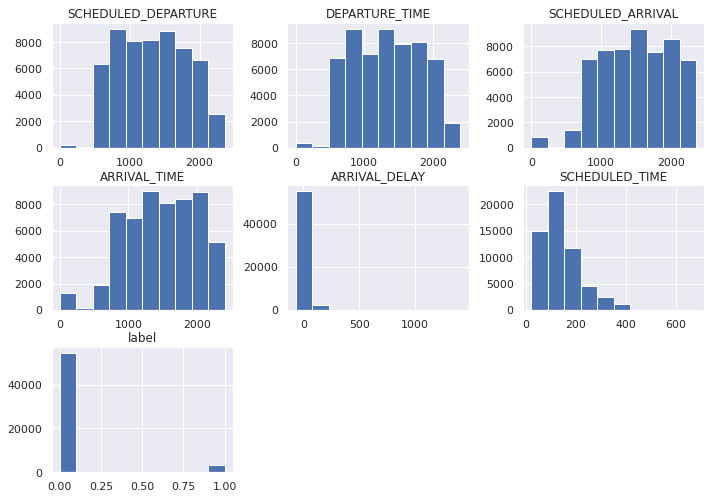

In [ ]:
df.hist()

In [ ]:
top_cities=df.DESTINATION_AIRPORT.value_counts().iloc[:20].rename_axis('DEST').reset_index(name='TOTAL_FLIGHTS')
city_list = top_cities['DEST'].tolist()
print(city_list)

['ATL', 'ORD', 'DFW', 'LAX', 'DEN', 'PHX', 'SFO', 'IAH', 'LAS', 'MSP', 'MCO', 'DTW', 'SEA', 'BOS', 'EWR', 'CLT', 'LGA', 'SLC', 'JFK', 'BWI']


In [ ]:
boolean_series = df.DESTINATION_AIRPORT.isin(city_list)
df = df[boolean_series]
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,label
0,US,SFO,CLT,20,18.0,806,811.0,5.0,286,0.0
1,DL,GSP,ATL,550,550.0,649,649.0,0.0,59,0.0
2,OO,BFL,DEN,550,556.0,920,940.0,20.0,150,0.0
3,US,OAK,PHX,600,558.0,855,903.0,8.0,115,0.0
4,NK,DTW,LGA,600,558.0,738,836.0,58.0,98,0.0


In [ ]:
codes, uniques = pd.factorize(pd.concat([df['ORIGIN_AIRPORT'], df['DESTINATION_AIRPORT']]))
df['ORIGIN_AIRPORT'] = codes[:len(df)] + 1
df['DESTINATION_AIRPORT'] = codes[len(df):] + 1
df.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,label
0,US,1,40,20,18.0,806,811.0,5.0,286,0.0
1,DL,2,13,550,550.0,649,649.0,0.0,59,0.0
2,OO,3,44,550,556.0,920,940.0,20.0,150,0.0
3,US,4,25,600,558.0,855,903.0,8.0,115,0.0
4,NK,5,12,600,558.0,738,836.0,58.0,98,0.0


Normalisation


In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
df.isna().sum().sum() #sprawdzenie czy dane są czysto numeryczne


0

In [ ]:
scaler = StandardScaler()
chosen_features=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME']
df[chosen_features]=scaler.fit_transform(df[chosen_features])
df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,label
0,US,-1.078229,0.384134,-2.601224,-2.549870,-1.280770,-1.213796,0.003251,1.701783,0.0
1,DL,-1.061190,-0.662744,-1.505866,-1.479295,-1.592235,-1.525474,-0.116221,-1.206701,0.0
2,OO,-1.044150,0.539228,-1.505866,-1.467221,-1.054611,-0.965608,0.361666,-0.040745,0.0
3,US,-1.027111,-0.197465,-1.402531,-1.463196,-1.183562,-1.036794,0.074934,-0.489189,0.0
4,NK,-1.010071,-0.701518,-1.402531,-1.463196,-1.415672,-1.165698,1.269653,-0.707005,0.0


In [ ]:
X = df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
        'SCHEDULED_TIME']]

Y = df['label']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def printScores(model, X, Y):

    print("Classification report:")
    print(classification_report(Y, model.predict(X)))
    print("Confusion matrix:")
    print(confusion_matrix(Y, model.predict(X)))


In [ ]:
model = LogisticRegression(solver = 'lbfgs')
model.fit(X,Y)
printScores(model, X, Y)


Classification report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     27764
         1.0       1.00      0.33      0.49      1727

    accuracy                           0.96     29491
   macro avg       0.98      0.66      0.74     29491
weighted avg       0.96      0.96      0.95     29491

Confusion matrix:
[[27762     2]
 [ 1162   565]]


In [ ]:
from sklearn.naive_bayes import GaussianNB
model2 = GaussianNB()
model2.fit(np.abs(X),Y)
from sklearn.svm import SVC
model3 = SVC(kernel='linear')
model3.fit(X,Y)
from sklearn.tree import DecisionTreeClassifier
model4 = DecisionTreeClassifier(max_depth=2)
model4.fit(X,Y)

DecisionTreeClassifier(max_depth=2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
def model_metrics(a, b):
    
    accuracy = metrics.accuracy_score(a, b)
    precision = precision_score(a, b)
    recall = recall_score(a, b)
    f1 = f1_score(a, b)

    print('Accuracy:', round(accuracy*100, 2),'%')
    print('Precision score:', round(precision*100, 2),'%')
    print('Recall score:', round(recall*100, 2),'%')
    print('F1 score:', round(f1*100, 2),'%')


In [ ]:
print('LogisticRegression')
y_pred_m1 = model.predict(X_test)
model_metrics(y_test, y_pred_m1)
print('Test:')
printScores(model, X_test, y_test)
print('Train:')
printScores(model, X_train, y_train)


LogisticRegression
Accuracy: 96.59 %
Precision score: 99.19 %
Recall score: 37.89 %
F1 score: 54.83 %
Test:
Classification report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      5577
         1.0       0.99      0.38      0.55       322

    accuracy                           0.97      5899
   macro avg       0.98      0.69      0.77      5899
weighted avg       0.97      0.97      0.96      5899

Confusion matrix:
[[5576    1]
 [ 200  122]]
Train:
Classification report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     22187
         1.0       1.00      0.32      0.48      1405

    accuracy                           0.96     23592
   macro avg       0.98      0.66      0.73     23592
weighted avg       0.96      0.96      0.95     23592

Confusion matrix:
[[22186     1]
 [  962   443]]


In [ ]:
print('naive_bayes')
y_pred_m2 = model2.predict(X_test)
model_metrics(y_test, y_pred_m2)
print('Test:')
printScores(model2, X_test, y_test)
print('Train:')
printScores(model2, X_train, y_train)

naive_bayes
Accuracy: 79.05 %
Precision score: 5.28 %
Recall score: 16.77 %
F1 score: 8.04 %
Test:
Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.88      5577
         1.0       0.05      0.17      0.08       322

    accuracy                           0.79      5899
   macro avg       0.50      0.50      0.48      5899
weighted avg       0.90      0.79      0.84      5899

Confusion matrix:
[[4609  968]
 [ 268   54]]
Train:
Classification report:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88     22187
         1.0       0.05      0.14      0.08      1405

    accuracy                           0.79     23592
   macro avg       0.50      0.49      0.48     23592
weighted avg       0.89      0.79      0.84     23592

Confusion matrix:
[[18502  3685]
 [ 1205   200]]


In [ ]:
print('SVC')
y_pred_m3 = model3.predict(X_test)
model_metrics(y_test, y_pred_m3)
print('Test:')
printScores(model3, X_test, y_test)
print('Train:')
printScores(model3, X_train, y_train)

SVC
Accuracy: 97.15 %
Precision score: 99.36 %
Recall score: 48.14 %
F1 score: 64.85 %
Test:
Classification report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      5577
         1.0       0.99      0.48      0.65       322

    accuracy                           0.97      5899
   macro avg       0.98      0.74      0.82      5899
weighted avg       0.97      0.97      0.97      5899

Confusion matrix:
[[5576    1]
 [ 167  155]]
Train:
Classification report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     22187
         1.0       1.00      0.44      0.61      1405

    accuracy                           0.97     23592
   macro avg       0.98      0.72      0.80     23592
weighted avg       0.97      0.97      0.96     23592

Confusion matrix:
[[22186     1]
 [  789   616]]


In [ ]:
print('DecisionTreeClassifier')
y_pred_m4 = model4.predict(X_test)
model_metrics(y_test, y_pred_m4)
print('Test:')
printScores(model4, X_test, y_test)
print('Train:')
printScores(model4, X_train, y_train)

DecisionTreeClassifier
Accuracy: 94.8 %
Precision score: 61.19 %
Recall score: 12.73 %
F1 score: 21.08 %
Test:
Classification report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      5577
         1.0       0.61      0.13      0.21       322

    accuracy                           0.95      5899
   macro avg       0.78      0.56      0.59      5899
weighted avg       0.93      0.95      0.93      5899

Confusion matrix:
[[5551   26]
 [ 281   41]]
Train:
Classification report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     22187
         1.0       0.62      0.09      0.16      1405

    accuracy                           0.94     23592
   macro avg       0.79      0.54      0.57     23592
weighted avg       0.93      0.94      0.92     23592

Confusion matrix:
[[22109    78]
 [ 1275   130]]


Triming the tree

In [ ]:
path = model4.cost_complexity_pruning_path(X_train, y_train)
# z obiektu path wyjmij wartości parametrów alpha i "nieczystości"
ccp_alphas, impurities = path.ccp_alphas, path.impurities

models = []
# iteruj w pętli po wartościach parametrów alpha
# dla każdego alpha stwórz drzewo, dofituj i dodaj model do listy clfs
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)


In [ ]:
best_index = 1
print(ccp_alphas[best_index])
best_model = DecisionTreeClassifier(ccp_alpha=ccp_alphas[best_index])
best_model.fit(X_train, y_train)
print('Test:')
printScores(best_model,X_test,y_test)
print('Train:')
printScores(best_model,X_train,y_train)


0.002076093817316174
Test:
Classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      5577
         1.0       0.69      0.45      0.54       322

    accuracy                           0.96      5899
   macro avg       0.83      0.72      0.76      5899
weighted avg       0.95      0.96      0.95      5899

Confusion matrix:
[[5511   66]
 [ 178  144]]
Train:
Classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     22187
         1.0       0.75      0.43      0.55      1405

    accuracy                           0.96     23592
   macro avg       0.86      0.71      0.76     23592
weighted avg       0.95      0.96      0.95     23592

Confusion matrix:
[[21986   201]
 [  796   609]]
